# Transient Luminous Event detection with Unsupervised Convolutional Variational Auto-Encoder

Authors:

Rasmus C. Jørgensen (s164044)

## Import packages

Please be aware that the dataloder uses the ReadMMIAfits function, made by Olivier Chanrion, DTU Space. It uses a lot of different packages, so please make sure they are installed. Additionally, a problem with the latest version of the pyproj package has made it necessary to manually set the PROJ_LIB environ path. Please edit line 29 in ReadMMIAfits_OCRE.py if you are using this version of the pyproj package, or remove it if not. It is currently pointing to the path on Rasmus C. Jørgensens local path, and will not run on another pc without changing it.

In [1]:
import os
import matplotlib.pyplot as plt
from ASIM_DataLoader_Slicing_Func import ASIM_DataLoader
import torch
from torch.utils.tensorboard import SummaryWriter
import math
from typing import *
from plotting import make_vae_plots
import numpy as np
import torch.nn.functional as F


## Define local path for data

Set the paths to the validation and training data.

In [2]:
local_path = r'C:\Users\rasse\Desktop\SpriteData\Data\ValiSet'
local_path_Train = r'C:\Users\rasse\Desktop\SpriteData\Data\TrainSet'

## Import the data

Run the ASIM Dataloader. It takes the path to the data, the loadStatusUpdate which defines how often it prints the load status, the upper and lower bound of the normalization (0 and 210 for the satuaration points of the instrument), the p parameter which indicate how large a percentage of the dataset we wish to use (30% in this case), and the size of the slizes (5000 in this case).

In [3]:
loadStatusUpdate = 200
ASIMDataSet_Vali = ASIM_DataLoader(local_path,  loadStatusUpdate,0,210, p = 0.3, sliceSize = 5000)
ASIMDataSet_Train = ASIM_DataLoader(local_path_Train, loadStatusUpdate,0,210, p = 0.3, sliceSize = 5000)


Files loaded:  0 / 1277
Files loaded:  200 / 1277
Files loaded:  400 / 1277
Files loaded:  600 / 1277
Files loaded:  800 / 1277
Files loaded:  1000 / 1277
Files loaded:  1200 / 1277
Files loaded:  0 / 11496
Files loaded:  200 / 11496
Files loaded:  400 / 11496
Files loaded:  600 / 11496
Files loaded:  800 / 11496
Files loaded:  1000 / 11496
Files loaded:  1200 / 11496
Files loaded:  1400 / 11496
Files loaded:  1600 / 11496
Files loaded:  1800 / 11496
Files loaded:  2000 / 11496
Files loaded:  2200 / 11496
Files loaded:  2400 / 11496
Files loaded:  2600 / 11496
Files loaded:  2800 / 11496
Files loaded:  3000 / 11496
Files loaded:  3200 / 11496
Files loaded:  3400 / 11496
Files loaded:  3600 / 11496
Files loaded:  3800 / 11496
Files loaded:  4000 / 11496
Files loaded:  4200 / 11496
Files loaded:  4400 / 11496
Files loaded:  4600 / 11496
Files loaded:  4800 / 11496
Files loaded:  5000 / 11496
Files loaded:  5200 / 11496
Files loaded:  5400 / 11496
Files loaded:  5600 / 11496
Files loaded:

# Run the dataloder
Letting batch_first = true means that the batch number will be the first dimension in each respective datatype, which means that we get the following structure:

dataType x batchNumber x data

Meaning we'll have:

[0:4] x ( [0:BatchSize] x [0:channel] x [0:len(data)] )

Where 0:4 will correspond to:

0 = 337 nm

1 = UV

2 = 777.4 nm

3 = Time

Additionally, let drop_last = True to remove the last batch. Since not all signals are dividable by the slicing size, the last batch can give problems if this is not true.

In [4]:
batch_size = 100
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 0}
ASIMData_Vali = torch.utils.data.DataLoader(ASIMDataSet_Vali, **params, drop_last=True)
ASIMData_Train = torch.utils.data.DataLoader(ASIMDataSet_Train, **params, drop_last=True)

## Plot data to make sure it works

Length of first dimension - expected 4 (datatypes):  4
Dimension of each datatype - expected batchNumber x dataLength:  torch.Size([100, 5000])


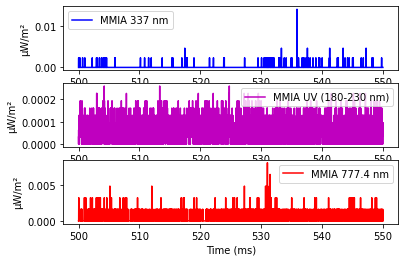

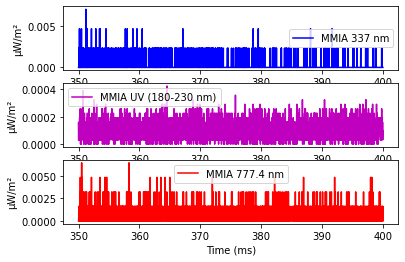

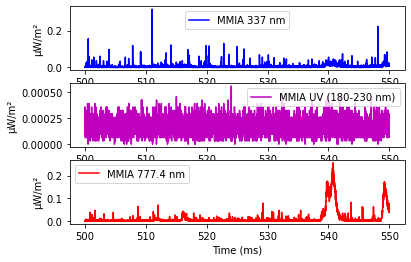

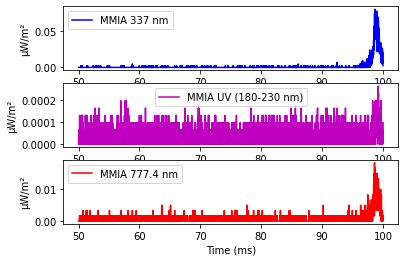

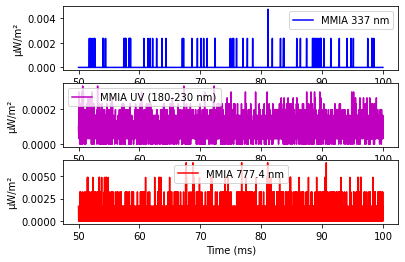

In [5]:
# Grab a single batch and plot a few of the events in it.
f = next(iter(ASIMData_Train))
p1d = f[0]
p2d = f[1]
p3d = f[2]
t = f[3]
print('Length of first dimension - expected 4 (datatypes): ', len(f))
print('Dimension of each datatype - expected batchNumber x dataLength: ', f[0].size())
StepsBetweenPlots = int(params['batch_size']/5) 

for i in range(0, len(f[0]), StepsBetweenPlots):
    plt.figure(i)
    ax1=plt.subplot(3,1,1)
    ax1.plot(t[i], p1d[i],'-b', label = 'MMIA 337 nm')
    ax1.legend();
    ax1.set_ylabel(u"\u03bcW/m²")
    ax1.set_xlabel('Time (ms)')
    ax2=plt.subplot(3,1,2,sharex=ax1)
    ax2.plot(t[i], p2d[i],'-m', label = 'MMIA UV (180-230 nm)')
    ax2.legend();
    ax2.set_ylabel(u"\u03bcW/m²")
    ax2.set_xlabel('Time (ms)')
    ax3=plt.subplot(3,1,3,sharex=ax1)
    ax3.plot(t[i], p3d[i],'-r', label = 'MMIA 777.4 nm')
    ax3.legend();
    ax3.set_ylabel(u"\u03bcW/m²")
    ax3.set_xlabel('Time (ms)')
    #plt.suptitle('Time of Measurement: %s (UTC) \n Observation ID: %i' % (ASIMDataSet.FrameTime[i][0].strftime("%d %b %Y %H:%M:%S"), ASIMDataSet.Obs_ID[i]))
    plt.show()

# Define the Reparametrization Trick

In [6]:
class ReparameterizedDiagonalGaussian(torch.distributions.Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: torch.Tensor, log_sigma:torch.Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> torch.Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> torch.Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> torch.Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        return self.mu + self.sigma * self.sample_epsilon() # <- your code
        
    def log_prob(self, z:torch.Tensor) -> torch.Tensor:
        """return the log probability: log `p(z)`"""
        pz = torch.distributions.normal.Normal(self.mu, self.sigma)
        return pz.log_prob(z)

# Define the CVAE

Define two help functions:

GetSize: Print the current size in the sequential net. Used for debuggin.

View: A view function compatible within the torch.nn.Sequential.

In [7]:
class GetSize(torch.nn.Module):
  def __init__(self):
    super(GetSize, self).__init__()
    
  def forward(self, x):
    print(x.shape)
   # f = x.shape
    return x

In [8]:
class View(torch.nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,
        
    def forward(self, x):
        return x.view(*self.shape)

Set up the net. Sequential blocks are used for encoding and decoding. 

In [1]:
# Define Latent Features
latent_features = 50
n = 699

# Define Network
class CVAENet(torch.nn.Module):
    def __init__(self, input_shape:torch.Size, latent_features:int, n):
        super(CVAENet, self).__init__()
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)
        self.batch_size = batch_size
        # Define Encoder
        self.Encode = torch.nn.Sequential(
            # First conv1
            torch.nn.Conv1d(in_channels=1,
                            out_channels=3,
                            kernel_size=4,
                            stride=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(2),
            torch.nn.BatchNorm1d(3),                
            # Conv to half size
            torch.nn.Conv1d(in_channels=3,
                            out_channels=15,
                            kernel_size=4,
                            stride=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(2),
            torch.nn.BatchNorm1d(15),
            # Conv to 1/4th
            torch.nn.Conv1d(in_channels=15,
                            out_channels=9,
                            kernel_size=4,
                            stride=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(2),
            torch.nn.BatchNorm1d(9),
            
            # Scale to 1/8th
            torch.nn.Conv1d(in_channels=9,
                            out_channels=3,
                            kernel_size=4,
                            stride=2),
                            
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(3), # BNBeforeLinLayer
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=n, out_features=500),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=500, out_features=250),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=250, out_features=latent_features*2),

        )        
        self.Decode = torch.nn.Sequential(
            torch.nn.Linear(in_features=latent_features, out_features=250),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=250, out_features=500),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=500, out_features=n),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(1), # BNBeforeLinLayer
            # Upscale to 1/8
            View([batch_size, 3, -1]),
            #GetSize(),
            torch.nn.ConvTranspose1d(in_channels=3,
                            out_channels=9,
                            kernel_size=4,
                            stride=2
            ),
            torch.nn.ReLU(),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.BatchNorm1d(9),
            
            # Upscale to 1/4
            torch.nn.ConvTranspose1d(in_channels=9,
                            out_channels=15,
                            kernel_size=4,
                            stride=2
            ),
            torch.nn.ReLU(),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.BatchNorm1d(15),
            
            # Upscale to 1/2
            torch.nn.ConvTranspose1d(in_channels=15,
                            out_channels=3,
                            kernel_size=4,
                            stride=2
            ),
            torch.nn.ReLU(),
            # There appears to be a problem with simply using scale_factor 2 here, 
            # because it results in an even number, where the encoder rounds down to an uneven. Hardcode it instead.
            torch.nn.Upsample(14997), 
            # Last conv to original data size
            torch.nn.BatchNorm1d(3),
            torch.nn.ConvTranspose1d(in_channels=3,
                            out_channels=3,
                            kernel_size=4,
                            stride=2,
                            output_padding = 1
            ),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(3),
            
            # Double the length for alpha and beta parameters in beta distribution
            torch.nn.ConvTranspose1d(in_channels=3,
                            out_channels=1,
                            kernel_size=4,
                            stride=1,
                            output_padding = 0
            ),
    )

        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))

    def posterior(self, x:torch.Tensor) -> torch.distributions.Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.Encode(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size:int=1)-> torch.distributions.Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:torch.Tensor) -> torch.distributions.Distribution:
        """return the distribution `p(x|z)`"""
        # Parameters for beta distribution. Chunk the double length, take exp() and return Beta distribution.
        alpha,beta = self.Decode(z).chunk(2,dim=-1)
        alpha = torch.exp(alpha)
        beta = torch.exp(beta)
        return torch.distributions.beta.Beta(alpha,beta)

    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample().view(batch_size, 1, -1) 
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""
        
        # degine the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'z': z}
    
# Define n, the length of the flattened layer
fCat = torch.cat((f[0],f[1],f[2]), dim=1).view(batch_size,1, -1)
vae = CVAENet([fCat.size()[2]],latent_features, n)
print(vae)

NameError: name 'torch' is not defined

In [10]:
B = 0
def reduce(x:torch.Tensor) -> torch.Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(torch.nn.Module):
    def __init__(self, b:float=B):
        super().__init__()
        self.b = b
        
    def forward(self, model:torch.nn.Module, x:torch.Tensor) -> Tuple[torch.Tensor, Dict]:
        
        # forward pass through the model
        outputs = model(x)
        
        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        log_px = reduce(px.log_prob(torch.clamp(x, 0.000001, 0.99999))) # Clamp the data to be sure we're within [0,1 range]. 0 and 1 are apparently not included in the Beta Distribution
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))
        
        # compute the ELBO
        kl = (torch.sum(qz.sigma**2 + qz.mu**2 - 2*torch.log(qz.sigma)-1, dim=-1)/2).mean()
        reconLoss = torch.sum(px.log_prob(torch.clamp(x, 0.000001, 0.99999)), dim=-1).mean()
        beta_elbo = reconLoss - self.b*kl
        
        # loss
        loss = -beta_elbo.mean()
       # print('loss: ', loss) 
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': beta_elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs
        

In [11]:
#loss = 0 
#diagnostics.clear()
#outputs = 0
vi = VariationalInference(b=B)
loss, diagnostics, outputs = vi(vae, fCat)
print(f"{'loss':6} | mean = {loss:10.3f}, shape: {list(loss.shape)}")
for key, tensor in diagnostics.items():
    print(f"{key:6} | mean = {tensor.mean():10.3f}, shape: {list(tensor.shape)}")

loss   | mean = 107476696.000, shape: []
elbo   | mean = -107476696.000, shape: []
log_px | mean = -107476696.000, shape: [100]
kl     | mean =      1.033, shape: []


# Initialize Training

In [12]:
from collections import defaultdict
# define the models, evaluator and optimizer

# VAE
vae = CVAENet([fCat.size()[2]],latent_features, n)

# Evaluator: Variational Inference
B = 0
vi = VariationalInference(b=B)

# Define the optimizer. Adam is being used.
optimizer = torch.optim.Adam(vae.parameters(), lr=1.5e-4) # Original: lr=1e-4

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

# Training

In [13]:
import matplotlib
num_epochs = 800

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

# move the model to the device
writer = SummaryWriter()
vae = vae.to(device)

# training..
while epoch < num_epochs:
    # Add the status if you are impatient, like we are.
    #if epoch % 1 == 0: # Print loading progress.
    #    print('Epoch Number: ',epoch, '/', num_epochs)
    epoch+= 1
    training_epoch_data = defaultdict(list)
    vae.train()
    vi = VariationalInference(b=B)
    print(B)
    B = min(epoch/400, 1)
    # Go through each batch in the training dataset using the loader
    for curBatch,x in enumerate(ASIMData_Train):
        # Concatenate the three spectra for the expected input of the net
        x = torch.cat((x[0],x[1],x[2]), dim=1).view(batch_size,1, -1)
        x = x.to(device)
          
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        # Define a counter for the torchboard
        # add the parameters to the torchboard
        Counter = curBatch*len(ASIMData_Train)
        writer.add_scalar("train/loss/",loss.item(), Counter)
        writer.add_scalar("train/ELBO", diagnostics['elbo'].mean().item(), Counter)
        writer.add_scalar("train/kl", diagnostics['kl'].mean().item(), Counter)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]
            

    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    # Evaluate on a single batch, do not propagate gradients
    with torch.no_grad():
        vae.eval()
        
        # Just load a single batch from the test loader
        x = next(iter(ASIMData_Vali))
        x = torch.cat((x[0],x[1],x[2]), dim=1).view(batch_size,1, -1)
        x = x.to(device)

        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        # Add to toarchboard aswell. Use epoch as counter here.
        writer.add_scalar("vali/loss/", loss.item(), epoch)
        writer.add_scalar("vali/ELBO", diagnostics['elbo'].mean().item(), epoch)
        writer.add_scalar("vali/kl", diagnostics['kl'].mean().item(), epoch)
        
        # gather data for the validation step
        for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]
    
# Flush writer to make sure everything is included.
writer.flush()

>> Using device: cuda:0
0
0.0025
0.005
0.0075
0.01
0.0125
0.015
0.0175
0.02
0.0225
0.025
0.0275
0.03
0.0325
0.035
0.0375
0.04
0.0425
0.045
0.0475
0.05
0.0525
0.055
0.0575
0.06
0.0625
0.065
0.0675
0.07
0.0725
0.075
0.0775
0.08
0.0825
0.085
0.0875
0.09
0.0925
0.095
0.0975
0.1
0.1025
0.105
0.1075
0.11
0.1125
0.115
0.1175
0.12
0.1225
0.125
0.1275
0.13
0.1325
0.135
0.1375
0.14
0.1425
0.145
0.1475
0.15
0.1525
0.155
0.1575
0.16
0.1625
0.165
0.1675
0.17
0.1725
0.175
0.1775
0.18
0.1825
0.185
0.1875
0.19
0.1925
0.195
0.1975
0.2
0.2025
0.205
0.2075
0.21
0.2125
0.215
0.2175
0.22
0.2225
0.225
0.2275
0.23
0.2325
0.235
0.2375
0.24
0.2425
0.245
0.2475
0.25
0.2525
0.255
0.2575
0.26
0.2625
0.265
0.2675
0.27
0.2725
0.275
0.2775
0.28
0.2825
0.285
0.2875
0.29
0.2925
0.295
0.2975
0.3
0.3025
0.305
0.3075
0.31
0.3125
0.315
0.3175
0.32
0.3225
0.325
0.3275
0.33
0.3325
0.335
0.3375
0.34
0.3425
0.345
0.3475
0.35
0.3525
0.355
0.3575
0.36
0.3625
0.365
0.3675
0.37
0.3725
0.375
0.3775
0.38
0.3825
0.385
0.3875
0.39
0.

# Inspect the results

Define the reconstruction as a sample.

In [14]:
x_reconstruct = outputs['px'].sample().view(batch_size ,3,-1).cpu().detach().numpy()

### Create plots of reconstruction
Define the filename and saveDir. saveName could for instance be an indiation of the parameters we are testing.
saveDir is simply the directory we save the files in. If it does not exist, create it.

Plot original data and the reconstruction side by side for comparison

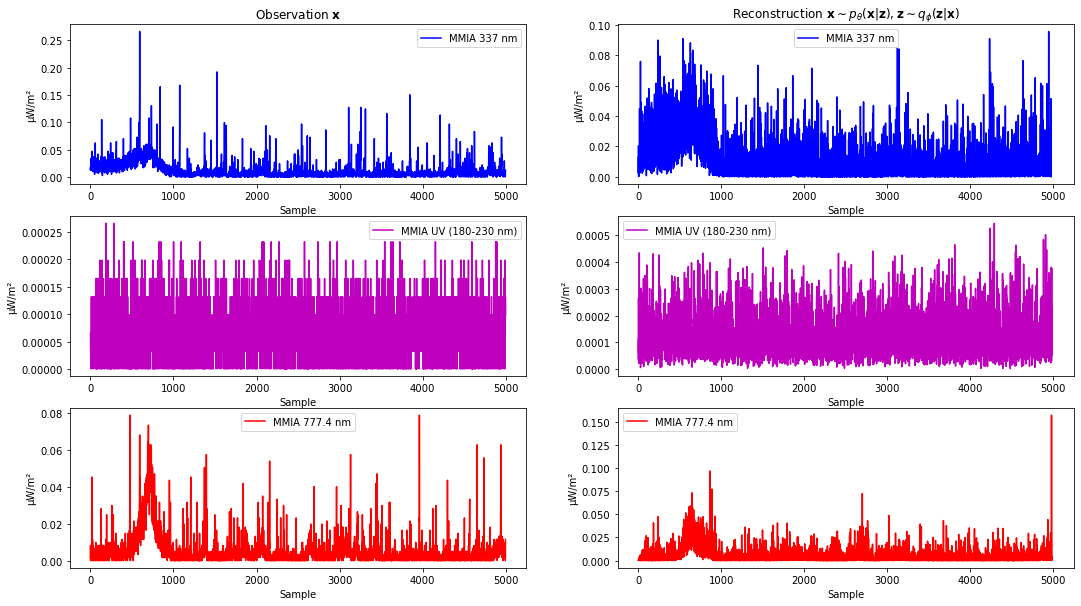

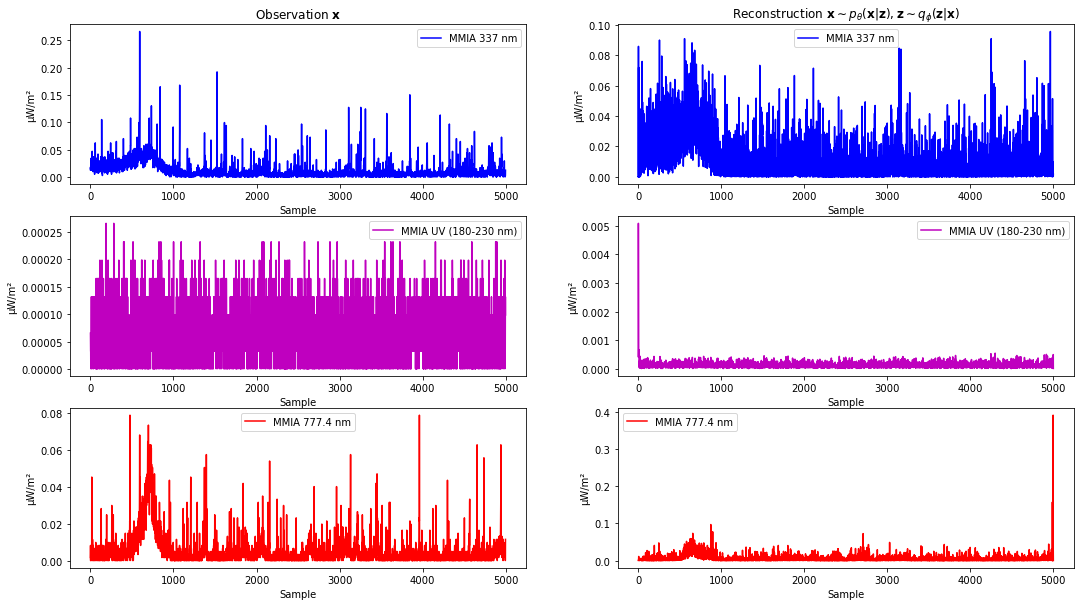

In [39]:
saveName = 'Epoch800_LatentSpace50_MaxPooling_WU400_NoDropout_BNBeforeLin_LearningR_1.5em4_LeakyRelu'
saveDir = os.path.join(r'C:\Users\rasse\Dropbox\DTU\DeepLearning\Project',saveName)
if not os.path.exists(saveDir):
    os.mkdir(saveDir)

numberPlot = 20  #change this to check different plots from the sample
# Plot original data without the edges to inspect the reconstruction with boundary problem. See report.
data = x[numberPlot].view(3,-1).cpu() 
fig = plt.figure(figsize=(18,10))
gs = fig.add_gridspec(3, 2)
ax1 = fig.add_subplot(gs[0,0])
ax1.plot(data[0][:],'-b', label = 'MMIA 337 nm')
ax1.legend();
ax1.set_ylabel(u"\u03bcW/m²")
ax1.set_xlabel('Sample')
ax1.set_title(r'Observation $\mathbf{x}$')

ax2=plt.subplot(gs[1,0],sharex=ax1)
ax2.plot(data[1][:],'-m', label = 'MMIA UV (180-230 nm)')
ax2.legend();
ax2.set_ylabel(u"\u03bcW/m²")
ax2.set_xlabel('Sample')

ax3=plt.subplot(gs[2,0],sharex=ax1)
ax3.plot(data[2][:],'-r', label = 'MMIA 777.4 nm')
ax3.legend();
ax3.set_ylabel(u"\u03bcW/m²")
ax3.set_xlabel('Sample')

# Plot reconstruction
ax4=plt.subplot(gs[0,1],sharex=ax1)
ax4.plot(x_reconstruct[numberPlot][0][20:-5],'-b', label = 'MMIA 337 nm')
ax4.legend();
ax4.set_ylabel(u"\u03bcW/m²")
ax4.set_xlabel('Sample')
ax4.set_title(r'Reconstruction $\mathbf{x} \sim p_\theta(\mathbf{x} | \mathbf{z}), \mathbf{z} \sim q_\phi(\mathbf{z} | \mathbf{x})$')

ax5=plt.subplot(gs[1,1],sharex=ax1)
ax5.plot(x_reconstruct[numberPlot][1][10:-5],'-m', label = 'MMIA UV (180-230 nm)')
ax5.legend();
ax5.set_ylabel(u"\u03bcW/m²")
ax5.set_xlabel('Sample')

ax6=plt.subplot(gs[2,1],sharex=ax1)
ax6.plot(x_reconstruct[numberPlot][2][10:-10],'-r', label = 'MMIA 777.4 nm')
ax6.legend();
ax6.set_ylabel(u"\u03bcW/m²")
ax6.set_xlabel('Sample')
fig.savefig(os.path.join(saveDir, 'ObservationAndRecon_EdgesOmitted.pdf'), transparent = True)  

# Plot data and reconstruction side by side with the edges, which shows the boundary problems. See report.
# Original data
fig = plt.figure(figsize=(18,10))
gs = fig.add_gridspec(3, 2)
ax1 = fig.add_subplot(gs[0,0])
ax1.plot(data[0][:],'-b', label = 'MMIA 337 nm')
ax1.legend();
ax1.set_ylabel(u"\u03bcW/m²")
ax1.set_xlabel('Sample')
ax1.set_title(r'Observation $\mathbf{x}$')

ax2=plt.subplot(gs[1,0],sharex=ax1)
ax2.plot(data[1][:],'-m', label = 'MMIA UV (180-230 nm)')
ax2.legend();
ax2.set_ylabel(u"\u03bcW/m²")
ax2.set_xlabel('Sample')

ax3=plt.subplot(gs[2,0],sharex=ax1)
ax3.plot(data[2][:],'-r', label = 'MMIA 777.4 nm')
ax3.legend();
ax3.set_ylabel(u"\u03bcW/m²")
ax3.set_xlabel('Sample')

# Reconstruction
ax4=plt.subplot(gs[0,1],sharex=ax1)
ax4.plot(x_reconstruct[numberPlot][0],'-b', label = 'MMIA 337 nm')
ax4.legend();
ax4.set_ylabel(u"\u03bcW/m²")
ax4.set_xlabel('Sample')
ax4.set_title(r'Reconstruction $\mathbf{x} \sim p_\theta(\mathbf{x} | \mathbf{z}), \mathbf{z} \sim q_\phi(\mathbf{z} | \mathbf{x})$')

ax5=plt.subplot(gs[1,1],sharex=ax1)
ax5.plot(x_reconstruct[numberPlot][1],'-m', label = 'MMIA UV (180-230 nm)')
ax5.legend();
ax5.set_ylabel(u"\u03bcW/m²")
ax5.set_xlabel('Sample')

ax6=plt.subplot(gs[2,1],sharex=ax1)
ax6.plot(x_reconstruct[numberPlot][2],'-r', label = 'MMIA 777.4 nm')
ax6.legend();
ax6.set_ylabel(u"\u03bcW/m²")
ax6.set_xlabel('Sample')
# Save fig
fig.savefig(os.path.join(saveDir, 'ObservationAndRecon_EdgesIncluded.pdf'), transparent = True)  


# Plot the latent space
Plot the feature map, the 2D projection, and the 3D projection of the latent space. Save it aswell.

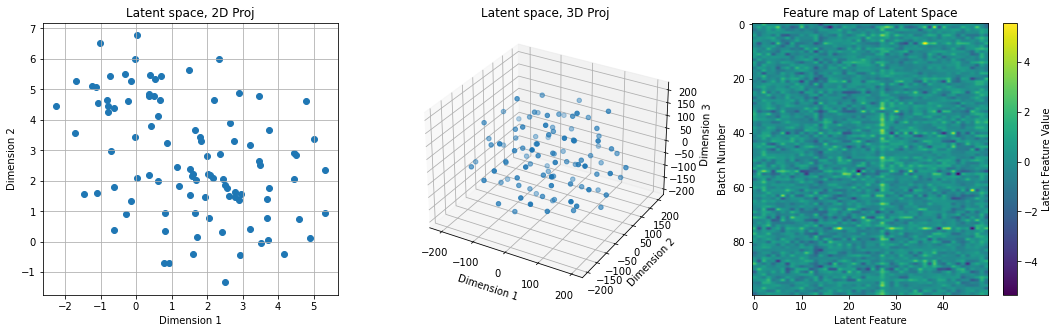

In [16]:
# Latent space
from sklearn.manifold import TSNE
# Define z for feature map, 2D proj and 3D proj.
z =  outputs['z'].view(batch_size, -1).cpu()
z_plot2D = TSNE(n_components=2).fit_transform(z.detach().numpy())
z_plot3D = TSNE(n_components=3).fit_transform(z.detach().numpy())

# Create the plot
# 2D Proj
fig = plt.figure(figsize=(18,5))
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0,0])
ax1.scatter(z_plot2D[:,0], z_plot2D[:,1])
ax1.set_title('Latent space, 2D Proj')
ax1.set_xlabel('Dimension 1')
ax1.set_ylabel('Dimension 2')
plt.grid()

# 3D proj
ax2 = fig.add_subplot(gs[0,1], projection = '3d')
ax2.scatter(z_plot3D[:,0], z_plot3D[:,1], z_plot3D[:,2])
ax2.set_xlabel('Dimension 1')
ax2.set_ylabel('Dimension 2')
ax2.set_zlabel('Dimension 3')
ax2.set_title('Latent space, 3D Proj')

# Feature map
ax3 = fig.add_subplot(gs[0,2])
plotZ = ax3.imshow(z.detach().numpy(), aspect='auto')#, vmin=-1, vmax=1)
ax3.set_title('Feature map of Latent Space')
cbar = fig.colorbar(plotZ)
ax3.set_ylabel('Batch Number')
ax3.set_xlabel('Latent Feature')
cbar.set_label('Latent Feature Value')
# Save figure
fig.savefig(os.path.join(saveDir, 'LatentSpace.pdf'), transparent = True)  



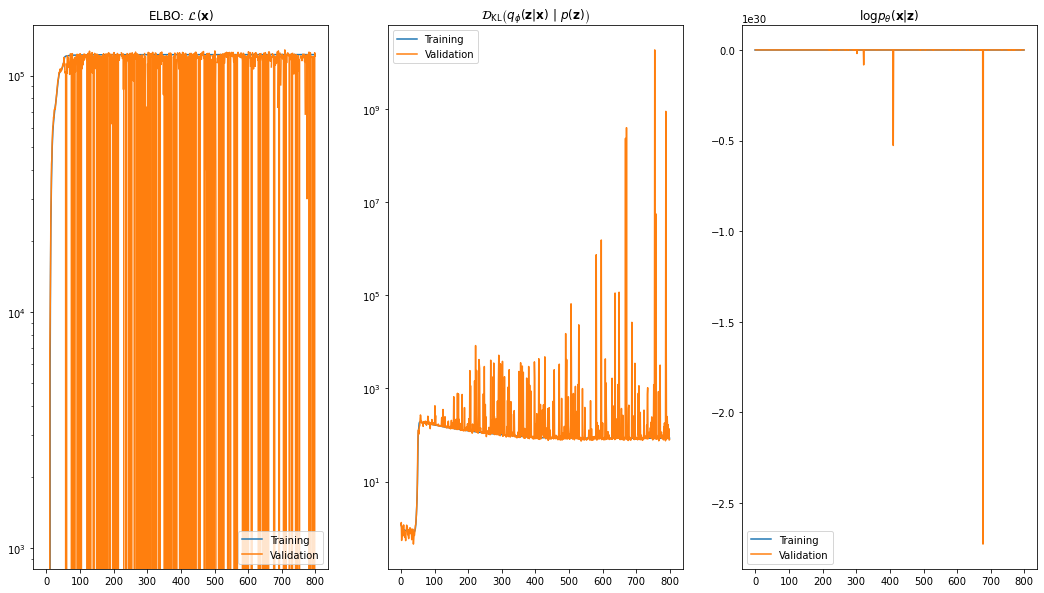

In [17]:
# Plot ELBO, KL, NLL
# A little redundant after including torchboard, but lets just let it be.
fig, axes = plt.subplots(1, 3, figsize=(18,10), squeeze=False)
ax = axes[0, 0]
ax.set_title(r'ELBO: $\mathcal{L} ( \mathbf{x} )$')
ax.semilogy(training_data['elbo'], label='Training')
ax.semilogy(validation_data['elbo'], label='Validation')
ax.legend()

# plot KL
ax = axes[0,1]
ax.set_title(r'$\mathcal{D}_{\operatorname{KL}}\left(q_\phi(\mathbf{z}|\mathbf{x})\ |\ p(\mathbf{z})\right)$')
ax.semilogy(training_data['kl'], label='Training')
ax.semilogy(validation_data['kl'], label='Validation')
ax.legend()

# plot NLL
ax = axes[0,2]
ax.set_title(r'$\log p_\theta(\mathbf{x} | \mathbf{z})$')
ax.plot(training_data['log_px'], label='Training')
ax.plot(validation_data['log_px'], label='Validation')
ax.legend()

# Save the model
Save the final model. Example of loading the model again:

the_model = TheModelClass(\*args, **kwargs) 

the_model.load_state_dict(torch.load(PATH))


In [18]:
torch.save(vae.state_dict(), os.path.join(r'C:\Users\rasse\Desktop\DL_ASIM\TrainedModel',saveName +'.pth'))